# Load Forest Cover

In [17]:
import rasterio
import xarray as xr
import pandas as pd
import numpy as np
import rioxarray
from pyproj import Transformer
from snowML.datapipe import get_geos as gg
import matplotlib.pyplot as plt

# Step 1 - Define Functions

In [2]:
def load(): 
    tif_path = "nlcd_tcc_conus_2021_v2021-4.tif"
    ds = rioxarray.open_rasterio(tif_path)
    land_cover_ds = ds.to_dataset(name="tree_canopy_cover") 
    return land_cover_ds

def get_geos_series(huc_id): 
    huc_lev = str(len(str(huc_id))).zfill(2)
    geos = gg.get_geos(huc_id, huc_lev)
    geo = geos.geometry
    return geos, geo

def clip_and_reproject(ds_land_cover, geo_series):
    # Get bounds in EPSG:4326
    minx, miny, maxx, maxy = geo_series.total_bounds
    # Transform bounds to EPSG:5070
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:5070", always_xy=True)
    minx_5070, miny_5070 = transformer.transform(minx, miny)
    maxx_5070, maxy_5070 = transformer.transform(maxx, maxy)

    # Clip the dataset in native CRS
    ds_subset = ds_land_cover.sel(
        x=slice(minx_5070, maxx_5070),
        y=slice(maxy_5070, miny_5070)  # reverse y order
    )

    # Reproject to EPSG:4326
    ds_subset = ds_subset.rio.write_crs("EPSG:5070")
    ds_reprojected = ds_subset.rio.reproject("EPSG:4326")

    return ds_reprojected

def subset_by_row(ds, row): 
    ds.rio.write_crs(row.crs, inplace=True)
    clipped_data = ds.rio.clip(row.geometry, drop=True) 
    return clipped_data

def remove_invals(ds, var_name="tree_canopy_cover", inval_value=255, quiet = True):
    """
    Replace invalid values in a variable with NaN and return the modified dataset.
    Prints the count and percentage of values replaced.

    Parameters:
        ds (xarray.Dataset): The dataset containing the variable.
        var_name (str): The name of the variable to clean.
        inval_value (int or float): The value considered invalid.

    Returns:
        xarray.Dataset: A copy of the dataset with invalid values replaced by NaN.
    """
    da = ds[var_name]
    total = da.size
    invalid_count = (da == inval_value).sum().item()
    invalid_percent = (invalid_count / total) * 100

    if not quiet: 
        print(f"Invalid value count ({inval_value}): {invalid_count}")
        print(f"Invalid value percentage: {invalid_percent:.2f}%")

    ds_clean = ds.copy()
    ds_clean[var_name] = da.where(da != inval_value, np.nan)
    ds_clean = ds_clean.sortby(['x', 'y'])

    return ds_clean
    

In [3]:
def plot_tree_canopy(ds_clean, var_name="tree_canopy_cover"):
    """
    Create a colorplot for the given variable in ds_clean with NaN values shown as black.
    It retains the x and y dimensions while removing the band dimension and sets axis labels to the values.
    
    Parameters:
        ds_clean (xarray.Dataset): The dataset with the variable.
        var_name (str): The name of the variable to plot.
    """
    # Extract the variable values and remove the 'band' dimension (keeping x and y)
    data = ds_clean[var_name].values.squeeze()  # Remove singleton dimensions

    # Mask NaN values
    masked_data = np.ma.masked_invalid(data)

    # Get x and y coordinates (assuming x and y are coordinate variables in the dataset)
    x_coords = ds_clean.coords['x'].values
    y_coords = ds_clean.coords['y'].values

    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Set NaN values to black in the colormap
    cmap = plt.cm.viridis
    cmap.set_bad(color='black')

    # Plot the data
    im = plt.imshow(masked_data, cmap=cmap)

    # Set the ticks and labels for x and y axes
    plt.xticks(np.linspace(0, len(x_coords)-1, 5), np.round(np.linspace(x_coords.min(), x_coords.max(), 5), 2))
    plt.yticks(np.linspace(0, len(y_coords)-1, 5), np.round(np.linspace(y_coords.min(), y_coords.max(), 5), 2))

    # Add a colorbar and title
    plt.colorbar(label="Tree Canopy Cover")
    plt.title(f"{var_name} (NaN = Black)")

    # Show the plot
    plt.show()



In [4]:
def calc_mean (ds): 
    # Take mean over 'y' and 'x', skipping NaNs
    mean_value = ds['tree_canopy_cover'].mean(dim=['x', 'y'], skipna=True).item()
    return mean_value   

# Step 2 Load Data 

In [5]:
land_cover_ds = load()

# Step 3: Run an Example 

In [6]:
huc_id = 180400090101
geos, geo = get_geos_series(huc_id) 
ds_small = clip_and_reproject(land_cover_ds, geo).squeeze()
mask = subset_by_row(ds_small, geos).squeeze()
ds_clean = remove_invals(mask)
ds_clean

<xarray.Dataset> Size: 2MB
Dimensions:            (x: 463, y: 412)
Coordinates:
  * x                  (x) float64 4kB -119.4 -119.4 -119.4 ... -119.2 -119.2
  * y                  (y) float64 3kB 37.74 37.74 37.74 ... 37.88 37.88 37.88
    band               int64 8B 1
    spatial_ref        int64 8B 0
Data variables:
    tree_canopy_cover  (y, x) float64 2MB nan nan nan nan ... nan nan nan nan

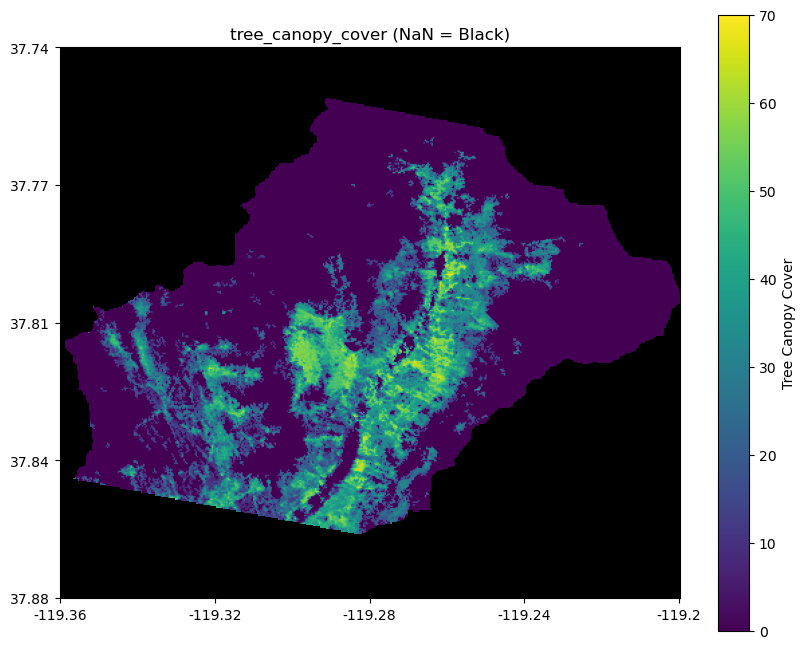

In [8]:
plot_tree_canopy(ds_clean)

In [9]:
mean_cover = calc_mean(ds_clean)
mean_cover

11.292495505090413

# Step 4 - Process FOr Multiple Hucs 

In [14]:
def forest_cover_all (huc_list): 
    land_cover_ds = load()
    mean_cover_list = []
    for huc_id in huc_list:
        geos, geo = get_geos_series(huc_id) 
        ds_small = clip_and_reproject(land_cover_ds, geo).squeeze()
        mask = subset_by_row(ds_small, geos).squeeze()
        ds_clean = remove_invals(mask)
        mean_cover = calc_mean(ds_clean)
        mean_cover_list.append(mean_cover)
    results = pd.DataFrame({"huc_id": huc_list, "Mean Forest Cover": mean_cover_list})
    return results

In [15]:
huc_list = ['180400090101', '180400090102']

In [18]:
results = forest_cover_all(huc_list)
results

,huc_id,Mean Forest Cover
0,180400090101,11.292496
1,180400090102,22.374891
